-------------------------------------------------------------------------------------------------------------------
Implementation of : "Online Label Recovery for Deep Learning-based communication through Error Correcting codes"

Author : Eric Soubigou

Date : Spring 2019

-------------------------------------------------------------------------------------------------------------------

Description :  Creation of a DFE like with Deep Learning technologies

In [2]:
# import sys
# sys.version
# Install libraries :
!pip3 install --user git+git://github.com/veeresht/CommPy.git@master
!pip3 install --user torch
!pip3 install --user matplotlib
!pip3 install --user scipy
print("DONE !")

  Cloning git://github.com/veeresht/CommPy.git (to revision master) to /tmp/pip-req-build-5fun4gxx
  Stored in directory: /tmp/pip-ephem-wheel-cache-kjctz397/wheels/d1/6a/31/8ddc70e8eb8a1c3ad344032ed43b4ebfccc41007e8850226d0
Successfully built scikit-commpy
DONE !


In [10]:
## Imports
from __future__ import print_function
import matplotlib.pyplot as plt
import pickle # For saving file
import copy as cpy

# Scipy
import scipy as sp
from scipy import signal

# Numpy
import numpy as np

# Compy
from commpy.filters import *
import commpy as cp
## Simulation import
from commpy.channelcoding.convcode import Trellis, conv_encode, viterbi_decode
from commpy.modulation import *

# For DL libraries 
import torch

# Keras
#from keras import backend as K
#from keras.models import Sequential
#from keras.layers.core import Dense, Lambda

In [4]:
""" Return if the number is a power of two. 
:num: An integer, number to test.
"""
def is_power_of_2(num):
    return num != 0 and ((num & (num - 1)) == 0)

""" Plot the power density spectrum of a given signal
:signal: A 1D-float-array, with the signal samples
:time_step: An integer, time step of the signal sampling 
"""
def plot_spectrum(signal, time_step):
    # Go in the frequency domain
    spectrum = np.abs(np.fft.fftshift(np.fft.fft(signal))) ** 2
    #   f, welch_estimate = sp.signal.welch(signal)
    freq = np.fft.fftshift(np.fft.fftfreq(signal.size, d=time_step))
    plt.plot(freq, spectrum, "r")
    #   plt.plot(f, welch_estimate, 'b')
    plt.yscale("log")
    plt.title("OFDM Spectrogram")
    plt.ylabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

In [58]:
"""
  Emitter class
"""


class Emiter:
    """ Class of the emiter.
  
  :cp_len: An integer, length of the cyclic-prefix of the OFDM.
  :nb_carriers: An integer, number of sub_carrier used to transmit data.
  :modulation_order: An integer, the modulation order.
  :nb_off_carriers: An integer, number of off carrier in OFDM scheme
  :trellis: A compy.channelcoding.Trellis, to encode the data
  :pilot_frequency: A integer, number of OFDM symbols/frame before transmitting a pilot
  
  Ex : | CP | CP | OFF | OFF | ON | ON | ... | ON |
  """

    def __init__(
        self,
        cp_len,
        nb_carriers,
        modulation_order,
        trellis,
        nb_off_carriers=0,
        pilot_frequency=8,
    ):
        self.cp_len = cp_len
        self.nb_carriers = nb_carriers
        self.nb_off_carriers = nb_off_carriers
        # Number of carriers that are used knowing the number of off-carrier
        self.nb_on_carriers = self.nb_carriers - self.nb_off_carriers

        # For the pilot management
        self.pilot_frequency = pilot_frequency
        self._symbols_counter = 0  # Is the counter of symbol for pilots.
        # When set to zero => need to send a pilot symbol

        if is_power_of_2(modulation_order):
            self.modulator = cp.modulation.PSKModem(modulation_order)
        else:
            print("Wrong modulation order : modulation order = ", modulation_order)

        # Generate OFDM pilot symbol
        self._pilot_symbols = np.expand_dims(
            self.modulator.modulate(
                np.zeros(
                    self.nb_on_carriers * int(np.log2(modulation_order)), dtype=int
                )
            ),
            axis=1,
        ).T

        # Test if the trellis is well-defined
        if trellis is not None:
            self.enc_trellis = trellis
        else:
            print("trellis is not defined")



    def get_trellis(self):
        """ Return the copy of trellis of the emiter
        """
        return cpy.deepcopy(self.enc_trellis)


    def modulate_frame(self, frame):
        """ Modulate and Map the frame. In other words, will perform the 
        Modulation and the Mapping and then perform the OFDM transmormation before 
        sending the data.
        :frame: The frame that has to be modulated.
        """
        # Mapping of the data
        mod_frame = self.modulator.modulate(frame)

        # Test if the division is equal to an integer or not
        if len(mod_frame) % self.nb_on_carriers != 0:
            nb_ofdm_group = (len(mod_frame) // self.nb_on_carriers) + 1
            # Add padding to the frame in order to get a interger number of PHY
            # frames used.

            padding = np.zeros(
                (self.nb_on_carriers - len(mod_frame) % self.nb_on_carriers)
                * self.modulator.num_bits_symbol,
                dtype=int,
            )
            # Add padding to the modulated frame
            mod_frame = np.concatenate(
                (mod_frame, self.modulator.modulate(padding)), axis=0
            )
        else:
            # No padding to perform
            nb_ofdm_group = len(mod_frame) // self.nb_on_carriers

        # Then reshape the frame to perform the modulation
        carriers = np.reshape(mod_frame, (nb_ofdm_group, self.nb_on_carriers))

        # Check wether we reached a pilot symbol
        if self._symbols_counter == 0:
            # Then concatenate the pilot symbol with the current frame
            carriers = np.concatenate((self._pilot_symbols, carriers), axis=0)
        # We increase the pilot counter and apply modulo for the given pilot frequency
        self._symbols_counter = (self._symbols_counter + 1) % self.pilot_frequency

        # Test if there are some off carriers
        if self.nb_off_carriers > 0:
            # Add the off_carriers
            carriers = np.concatenate(
                (np.zeros((nb_ofdm_group, self.nb_off_carriers)), carriers), axis=1
            )

        # Then use the matrix to transform them into OFDM symbols
        ofdm_signal = sp.fftpack.ifft(carriers, axis=1)
        #  Add the cyclic prefix
        ofdm_signal_cp = np.concatenate(
            (ofdm_signal[:, self.nb_carriers - self.cp_len :], ofdm_signal), axis=1
        )

        # Return the global frame
        return np.ravel(ofdm_signal_cp)

    """ Encode the bit frame according to the defined trellis of the emiter
    :frame: The frame that has to be encoded.
    """

    def encode(self, frame):
        # Channel coding of the frame
        return cp.channelcoding.conv_encode(frame, self.enc_trellis)

In [26]:
"""
  AWGN Channel class
"""


class AWGN_Channel:

    """ Class of the AWGN channel.
    :mean: A float, mean of the gaussian noise.
    :var: A float, variance of the gaussian noise.
    :non_lin_coeff: A float, value of the non-linearity coefficient of the channel.
    :iq_imbalance: A float, value of the iq_imbalance.
    """

    def __init__(self, mean, var, non_lin_coeff=0, iq_imbalance=None):
        self.mean = mean
        self.var = var
        self.gamma = non_lin_coeff
        self.beta = iq_imbalance

    def get_trough(self, mod_frame):
        """ Return the value of the frame after get through the channel
        :mod_frame: An array, input of of the channel. Is the modulated frame from an 
        emiter.
        """
        # Test if there is a non-linearity
        mod_frame = self.add_iq_imbalance(mod_frame)
        # Non linearity
        mod_frame -= self.gamma * (np.abs(mod_frame)) ** 2 * mod_frame
        # Add Gaussian noise
        output = mod_frame + np.random.normal(self.mean, self.var, mod_frame.shape)
        #  Add second non linearity
        output = self.add_iq_imbalance(output)
        # Non linearity for the second time
        output -= self.gamma * np.abs(output) ** 2 * output
        return output



    def add_iq_imbalance(self, x):
        """ Add IQ imbalance to a given array
        :x: An array, input which will be imbalanced accodring to attributes of the 
        AWGN channel class
        """
        if self.beta is not None:
            return slef.beta * np.real(x) + 1j * np.imag(x)
        else:
            return x



    def set_var(self, snr_db, modulation_order):
        """ Set the variance of the gaussian noise of the channel
        :snr_db: A float, Value of the Signal to Noise ratio in dB
        :modulation_order: An integer, is the moudlation order of the constellation used
        """
        snr = 10 ** (snr_db / 10)
        # To define a bit better than it is right now
        channel_taps = 1
        var_signal = 1
        shaped_signal = 1
        self.var = (
            np.linalg.norm(shaped_signal) * var_signal * np.linalg.norm(channel_taps)
        ) / (2 * np.log2(modulation_order) * snr)




In [107]:
"""
    Equalizer class
"""


class Equalizer:
    """ Class of Equalizers
    :pilot_symbols: An 1D-float array, beeing the pilots symbol used to estimate 
    """

    def __init__(self, pilot_symbols):
        self.pilot_symbols = pilot_symbols
        self.estimation = None

    def equalize(self, symbols_to_equalize):
        """ Equalizes the received frame
        :symbols_to_equalize: A 2D-float-array, with the symbol to equalize
        """
        return np.multiply(symbols_to_equalize, self.estimation)


class Zero_Forcing(Equalizer):
    """ Zero Forcing equalizers class
    """
    def __init__(self, pilot_symbols):
        super().__init__(pilot_symbols)
        self._name = "Zero-Forcing"

    def estimate(self, received_pilot_symbols):
        self.estimation = np.divide(
            np.multiply(received_pilot_symbols, np.conjugate(self.pilot_symbols)),
            np.power(np.abs(self.pilot_symbols), 2),
        )


class MMSE(Equalizer):
    """ MMSE equalizers class
    
    """
    def __init__(self, pilot_symbols):
        super().__init__(pilot_symbols)
        self._name = "MMSE"

    def estimate(self, received_pilot_symbols, noise_var_est):
        self.estimation = np.divide(
            np.multiply(received_pilot_symbols, np.conjugate(self.pilot_symbols)),
            np.abs(self.pilot_symbols) + noise_var_est,
        )



# class NN_Equalizer(Equalizer):
    # """
    # """

#     def __init__(self, pilot_symbols):


def switch_init_equalizer(equalizer_name, pilot_symbols):
    """ Instantiate the wanted equalizer given the name of the equalizer
    """
    equalizers = {
        "ZF": Zero_Forcing(pilot_symbols=pilot_symbols),
        "MMSE": MMSE(pilot_symbols=pilot_symbols),
    }
    return equalizers.get(equalizer_name, None)

In [117]:
"""
    Receiver class
"""


class Receiver:

    """ Class of the Receivers
    
    :cp_len: An integer, length of the cyclic-prefix of the OFDM.
    :nb_carriers: An integer, number of sub_carrier used to transmit data.
    :modulation_order: An integer, the modulation order.
    :nb_off_carriers: An integer, number of off carrier in OFDM scheme
    """

    def __init__(
        self,
        cp_len,
        nb_carriers,
        modulation_order,
        trellis,
        nb_off_carriers=0,
        pilot_frequency=8,
        equalizer_type=None,
    ):
        self.cp_len = cp_len
        self.nb_carriers = nb_carriers
        self.nb_off_carriers = nb_off_carriers
        # Number of carriers that are used knowing the number of off-carrier
        self.nb_on_carriers = self.nb_carriers - self.nb_off_carriers

        # For the pilot management
        self.pilot_frequency = pilot_frequency
        self._symbols_counter = 0  # Is the counter of pilot.
        # When set to zero => need to process an OFDM pilot symbol

        if is_power_of_2(modulation_order):
            self.demodulator = cp.modulation.PSKModem(modulation_order)
        else:
            print("Wrong modulation order : modulation order = ", modulation_order)

        # Generate OFDM pilot symbol to use it for future equalization processes
        self._pilot_symbol = np.expand_dims(
            self.demodulator.modulate(
                np.zeros(
                    self.nb_on_carriers * int(np.log2(modulation_order)), dtype=int
                )
            ),
            axis=1,
        ).T

        # Test if the trellis is well-defined
        if trellis is not None:
            self.dec_trellis = trellis
        else:
            print("trellis is not defined")

        # Instanciate the Equalizer
        if equalizer_type is not None:
            # Test which type of equalizer
            self.equalizer = switch_init_equalizer(equalizer_type, self._pilot_symbol)
        else:
            self.equalizer = None

    def demodulate_frame(self, frame, demod_type="hard"):
        """ Demodulate a OFDM received frame
        :frame: A 1D array, received frame to demodulate (following OFDM scheme).
        :demod_type: 'hard'/'soft', type of demodulation wanted.
        """
        # We reshape the frame at the reception
        nb_ofdm_group = len(frame) // (self.cp_len + self.nb_carriers)
        received_frame = np.reshape(
            frame, (nb_ofdm_group, (self.cp_len + self.nb_carriers))
        )
        # We delete the cyclic prefix from each frame
        received_frame = received_frame[:, self.cp_len :]
        # We perform the fft to go from OFDM modulation to standard maping
        time_frame = sp.fftpack.fft(received_frame, axis=1)
        # Then we delete the part of off-carriers
        #         time_frame = np.ravel(time_frame[:, self.nb_off_carriers :])
        time_frame = time_frame[:, self.nb_off_carriers :]

        # Check wether we reached a pilot symbol
        if self._symbols_counter == 0:
            # Then extract the pilot symbol from the current frame
            pilot_symbol, time_frame = np.vsplit(time_frame, [1])
            if self.equalizer is not None:
                # Perform the estimation of the channel for the equalizer
                self.equalizer.estimate(pilot_symbol)
        # We increase the pilot counter and apply modulo for the given pilot frequency
        self._symbols_counter = (self._symbols_counter + 1) % self.pilot_frequency

        # Use of an equalizer ?
        if self.equalizer is not None:
            eq_time_frame = self.equalizer.equalize(time_frame)
        else:
            # No equalization performed
            eq_time_frame = time_frame

        # Reshape the time frame in a 1D-array
        eq_time_frame = np.ravel(eq_time_frame)

        # Then we perform the demodulation
        return self.demodulator.demodulate(eq_time_frame, demod_type)

    def decode(self, enc_frame):
        """ Decoding an encoded frame according to the trellis of the receiver.
        :enc_frame: A 1D float array, encoded frame to decode.
        """
        # Decode the received frame according to the trellis
        return cp.channelcoding.viterbi_decode(
            enc_frame, self.dec_trellis, decoding_type="hard"
        )

Modulation exponent:  3


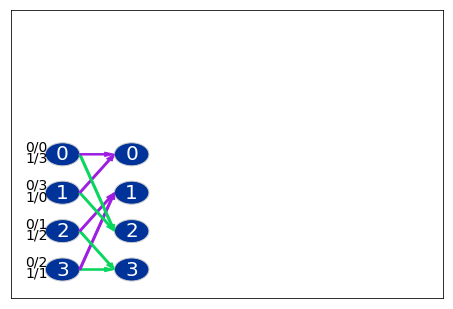

The frame length is :  (20000,)
The encoded frame length is :  (40004,)
The modulated frame shape is :  (15120,)


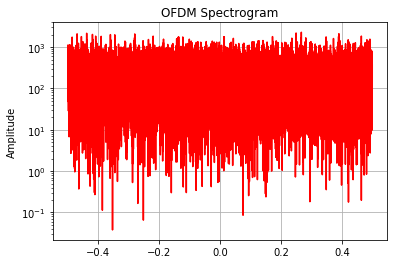

The demodulated frame length is :  (40128,)
The demodulated frame length is :  (40004,)
The decoded frame length is :  (20002,)
The shrink decoded frame length is :  (20000,)
The number of error is : 0


In [119]:
"""
  Unitary test of Emiter class
"""
# Channel code parameters + trellis generation
mem_size = np.array([2])
g_matrix = np.array([[0o5, 0o7]])
trellis = Trellis(mem_size, g_matrix)

#  Modulation parameters
modulation_order = 8
frame_length = 20000

# OFDM parameters (According to the paper "Online Label Recovery for Deep Learning-based communication through Error Correcting codes")
nb_carriers = 64
cp_length = 8
off_carrier = 0
equalizer = "ZF"

# Creation of the emiter
emiter = Emiter(
    cp_length, nb_carriers, modulation_order, trellis, nb_off_carriers=off_carrier
)

# Basic unitary test
print("Modulation exponent: ", emiter.modulator.num_bits_symbol)

# Vizualization of trellis
(emiter.get_trellis()).visualize()

### Test the frame modulation
# Generation of a frame
frame = np.random.randint(0, high=2, size=(frame_length))
print("The frame length is : ", frame.shape)

# Channel Coding by the emiter
enc_frame = emiter.encode(frame)
print("The encoded frame length is : ", enc_frame.shape)

# Modulation operation by the emiter
mod_frame = emiter.modulate_frame(enc_frame)
print("The modulated frame shape is : ", mod_frame.shape)

# Verification of the spectrum :
plot_spectrum(mod_frame, 1)

# Get through channel
mean = 0
var = 0
awgn_channel = AWGN_Channel(mean, var, non_lin_coeff=0, iq_imbalance=None)

received_frame = awgn_channel.get_trough(mod_frame)

# Creation of the receiver
receiver = Receiver(
    cp_length, nb_carriers, modulation_order, trellis, nb_off_carriers=off_carrier, equalizer_type=equalizer
)

# Demodulation of the received frame
demod_frame = receiver.demodulate_frame(received_frame, demod_type="hard")
print("The demodulated frame length is : ", demod_frame.shape)

# Shrink for convinience
demod_frame = demod_frame[: len(enc_frame)]
print("The demodulated frame length is : ", demod_frame.shape)

# Decoding frame
dec_frame = receiver.decode(demod_frame)
print("The decoded frame length is : ", dec_frame.shape)

# Shrink the last part of the decoded frame before comparing the results
dec_frame = dec_frame[: len(frame)]
print("The shrink decoded frame length is : ", dec_frame.shape)

# Comparing the error
nb_err = np.sum(dec_frame != frame)
print("The number of error is :", nb_err)

In [115]:

class PHY_Layer:
    """ PHY layer class
    :emiter: An Emiter, emiter of the Phy layer
    :receiver: An Receiver, receiver of the Phy layer
    :channel: A Channel, 
    """
    def __init__(self, emiter, receiver, channel):
        self.emiter = emiter
        self.receiver = receiver
        self.channel = channel   

    def process_frame(self, frame):
        # Encode the frame
        enc_frame = self.emiter.encode(frame)
        # Modulate the frame
        mod_frame = self.emiter.modulate_frame(enc_frame)
        # Go through the channel
        channel_frame = awgn_channel.get_trough(mod_frame)
        # Demodulation of the received frame
        demod_frame = receiver.demodulate_frame(channel_frame, demod_type="hard")
        # Shrink for convinience
        demod_frame = demod_frame[: len(enc_frame)]
        # Decoding frame
        dec_frame = receiver.decode(demod_frame)
        # Shrink the last part of the decoded frame before comparing the results
        return dec_frame[: len(frame)]
        

BER simulation completed at  0.0  % BER =  0.4215  for  SNR =  0  dB.
BER simulation completed at  10.0  % BER =  0.3395  for  SNR =  2  dB.
BER simulation completed at  20.0  % BER =  0.1915  for  SNR =  4  dB.
BER simulation completed at  30.0  % BER =  0.038461538461538464  for  SNR =  6  dB.
BER simulation completed at  40.0  % BER =  0.0044  for  SNR =  8  dB.
BER simulation completed at  50.0  % BER =  0.0  for  SNR =  10  dB.


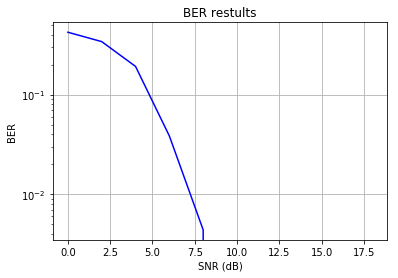

In [118]:
### Monte-carlo simulations

# Monte-Carlo parameters
min_error_frame = 20
max_test = 50

# SNR / BER parameters
step_db = 2
min_snr = 0
max_snr = 20
snr_db = np.array(range(min_snr, max_snr, step_db))
ber = np.zeros(len(snr_db))

# Channel parameters
non_lin_coeff = 0
iq_imbalance = None

# OFDM parameters (According to the paper "Online Label Recovery for 
# Deep Learning-based communication through Error Correcting codes")
nb_carriers = 64
cp_length = 8
off_carrier = 0

# Type of Equalizer at the receiver side
equalizer = None

# Emiter / Receiver parameter for trellis
mem_size = np.array([2])
g_matrix = np.array([[0o5, 0o7]])
trellis = Trellis(mem_size, g_matrix)

# Frame length
frame_length = 100

# Creation of the emiter
emiter = Emiter(
    cp_length, nb_carriers, modulation_order, trellis, nb_off_carriers=off_carrier
)
# Creation of the receiver
receiver = Receiver(
    cp_length, nb_carriers, modulation_order, trellis, nb_off_carriers=off_carrier
)

# Creation of the AWGN Channel
awgn_channel = AWGN_Channel(
    mean=0, var=0, non_lin_coeff=non_lin_coeff, iq_imbalance=iq_imbalance
)

# Creation of the PHY Layer
phy_layer = PHY_Layer(emiter, receiver, awgn_channel)

# for ind_snr in range(len(snr_db)):
ind_snr = 0
while (ind_snr < len(snr_db)) and (not (ind_snr > 0) or (ber[ind_snr - 1] > 0)):
    # Init variables
    nb_tries = 0
    nb_frame_error = 0
    global_error_nb = 0
    # Set the snr
    phy_layer.channel.set_var(snr_db[ind_snr], modulation_order)
    # Monte-Carlo method
    while (nb_tries < max_test) and (nb_frame_error < min_error_frame):
        # Generation of the frames
        frame = np.random.randint(0, high=2, size=frame_length)
        # Send the frame to the physical layer
        recieved_frame = phy_layer.process_frame(frame)
        # Counting errors
        errors_num = np.sum(recieved_frame != frame)
        # Look at the number of mistake
        if errors_num > 0:
            # Add the number of frame errors
            nb_frame_error = nb_frame_error + 1
        global_error_nb = global_error_nb + errors_num
        # increase the number of tries
        nb_tries = nb_tries + 1
    ber[ind_snr] = global_error_nb / (nb_tries * frame_length)
    print(
        "BER simulation completed at ",
        (100 * ind_snr / len(snr_db)),
        " %",
        "BER = ",
        ber[ind_snr],
        " for  SNR = ",
        snr_db[ind_snr],
        " dB.",
    )
    # Increase the snr index
    ind_snr += 1

ber_dict = {
    "trellis": {"mem_size": mem_size, "g_matrix": g_matrix},
    "phy_param": {"frame_length": frame_length, "modulation_order": modulation_order},
    "channel_param": {"non_lin_coeff": non_lin_coeff, "iq_imbalance": iq_imbalance},
    "monte_carlo_param": {"min_error_frame": min_error_frame, "max_test": max_test},
    "results": {"snr_db": snr_db, "ber": ber},
}

# Save results in file
filename = "./results/OFDM_equalizer_{}_non_lin_coeff_{}_iq_imbalance_{}.pickle".format(
    str(equalizer), str(non_lin_coeff), str(iq_imbalance)
)

with open(filename, "wb") as handle:
    pickle.dump(ber_dict, handle)

# Display results
plt.plot(snr_db, ber, "b")
plt.yscale("log")
plt.title("BER restults")
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.grid(True)
plt.show()

In [87]:
a = np.array([1, 2 ,3])
b = np.array([
    [1, 2, 3],
    [2, 2, 2],
    [2, 2, 2]])

c = np.multiply(a,b)
print(c)




[[1 4 9]
 [2 4 6]
 [2 4 6]]
